In [ ]:
# CELDA 0: Andamiaje completo de bootcamp IA (CV + NLP) en Drive
# -----------------------------------------------------------------------------------
from google.colab import drive
drive.mount('/content/drive')

import os
from pathlib import Path
import textwrap
from datetime import date

# Ruta base en Drive
ROOT = Path("/content/drive/MyDrive/modulo_4_cv_nlp")

# Carpetas mínimas
DIRS = [
    "data/raw",
    "data/processed",
    "models/cv",
    "models/nlp",
    "metrics/cv",
    "metrics/nlp",
    "notebooks",
    "src/cv",
    "src/nlp",
    "reports/figures",
]

for d in DIRS:
    (ROOT / d).mkdir(parents=True, exist_ok=True)

# README
readme = textwrap.dedent(f"""\
# Módulo 4: Visión Artificial + PLN – Bootcamp IA Básico
Fecha de creación: {date.today().isoformat()}

Estructura mínima para desarrollar dos modelos:
- Visión Artificial: clasificador de imágenes.
- PLN: análisis de sentimientos.

Instrucción: debes cargar tu dataset manualmente en `data/raw/`
""")
(ROOT / "README.md").write_text(readme, encoding="utf-8")

# requirements.txt
req = textwrap.dedent("""\
numpy
pandas
scikit-learn
matplotlib
tensorflow
torch
transformers
datasets
nltk
""")
(ROOT / "requirements.txt").write_text(req, encoding="utf-8")

# Archivos plantilla en src/
archivos = {
    "src/cv/preprocesamiento.py": '''"""
Preprocesamiento de imágenes.
"""

def cargar_y_preprocesar_imagen(path_img):
    """Carga y transforma imagen individual."""
    pass  # TODO: usar PIL o tf.keras.utils.load_img()

def aplicar_aumentos(imagen):
    """Aumentos para entrenamiento."""
    pass  # TODO: usar keras.preprocessing o albumentations
''',

    "src/cv/modelo_base.py": '''"""
Modelo base CV con transferencia.
"""

def crear_modelo_transfer(num_clases):
    """Crea MobileNetV2 + capa final softmax."""
    pass  # TODO: tf.keras.applications.MobileNetV2
''',

    "src/nlp/limpieza_texto.py": '''"""
Limpieza básica de texto.
"""

def limpiar(texto):
    """Limpia minúsculas, stopwords, signos."""
    pass  # TODO: usar re, nltk o spaCy
''',

    "src/nlp/modelo_sentimiento.py": '''"""
Modelo de sentimiento básico.
"""

def crear_modelo_basico():
    """TF-IDF + regresión logística."""
    pass  # TODO: usar sklearn.pipeline
''',
}

# Guardar archivos plantilla
for ruta_rel, contenido in archivos.items():
    archivo = ROOT / ruta_rel
    archivo.parent.mkdir(parents=True, exist_ok=True)
    archivo.write_text(contenido, encoding="utf-8")

print(f"[ok] Estructura y archivos plantilla generados en:\n{ROOT}")


Mounted at /content/drive
[ok] Estructura y archivos plantilla generados en:
/content/drive/MyDrive/modulo_4_cv_nlp


,# imágenes
dandelion,1052
tulip,993
rose,784
daisy,764
sunflower,733


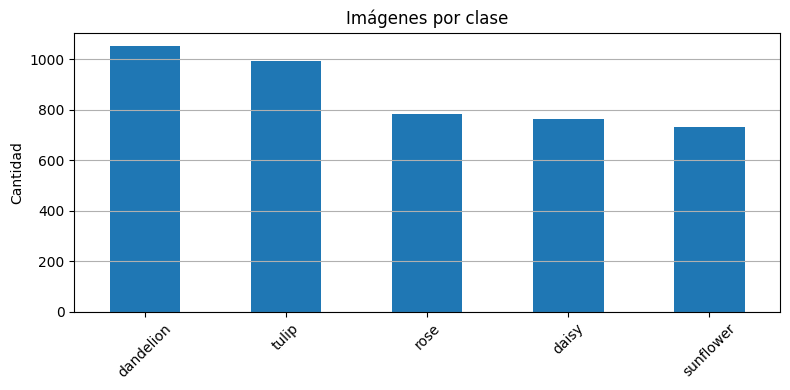

In [4]:
# CELDA 1: Verificación del dataset manual en data/raw/flowers/
# -----------------------------------------------------------------------------------
from pathlib import Path
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd

ROOT = Path("/content/drive/MyDrive/modulo_4_cv_nlp")
RAW = ROOT / "data" / "raw" / "flowers"

# Verificar existencia
assert RAW.exists(), "No se encontró la carpeta: data/raw/flowers/"
clases = [d.name for d in RAW.iterdir() if d.is_dir()]
assert len(clases) >= 2, "Se necesitan al menos dos carpetas (clases) en flowers/"

# Contar imágenes por clase
conteo = {}
for clase in clases:
    conteo[clase] = len(list((RAW / clase).glob("*.jpg")))

# Mostrar resumen
df = pd.DataFrame.from_dict(conteo, orient="index", columns=["# imágenes"]).sort_values("# imágenes", ascending=False)
display(df)

# Visualización gráfica
df.plot(kind="bar", figsize=(8,4), legend=False, title="Imágenes por clase")
plt.xticks(rotation=45)
plt.ylabel("Cantidad")
plt.grid(axis="y")
plt.tight_layout()
plt.show()


In [5]:
# CELDA 2: Split 80/20 y copia a data/processed/flowers/train|val/
# -----------------------------------------------------------------------------------
import shutil, random
from pathlib import Path

ROOT = Path("/content/drive/MyDrive/modulo_4_cv_nlp")
RAW = ROOT / "data" / "raw" / "flowers"
PROC = ROOT / "data" / "processed" / "flowers"

# Configuración
SPLITS = ["train", "val"]
FRAC_TRAIN = 0.8
EXT = [".jpg", ".jpeg", ".png"]
random.seed(42)

# Verificar dataset crudo
assert RAW.exists(), "Falta carpeta data/raw/flowers/"
clases = [d.name for d in RAW.iterdir() if d.is_dir()]
assert len(clases) >= 2, "Se necesitan al menos dos clases."

# Crear carpetas de salida
for split in SPLITS:
    for clase in clases:
        destino = PROC / split / clase
        destino.mkdir(parents=True, exist_ok=True)

# Procesar cada clase
for clase in clases:
    archivos = [p for p in (RAW / clase).glob("*") if p.suffix.lower() in EXT]
    random.shuffle(archivos)
    k = int(FRAC_TRAIN * len(archivos))
    train, val = archivos[:k], archivos[k:]

    for f in train:
        shutil.copy2(f, PROC / "train" / clase / f.name)
    for f in val:
        shutil.copy2(f, PROC / "val" / clase / f.name)

print(f"[ok] División completada en {PROC}")


[ok] División completada en /content/drive/MyDrive/modulo_4_cv_nlp/data/processed/flowers


Found 3459 files belonging to 5 classes.
Found 867 files belonging to 5 classes.


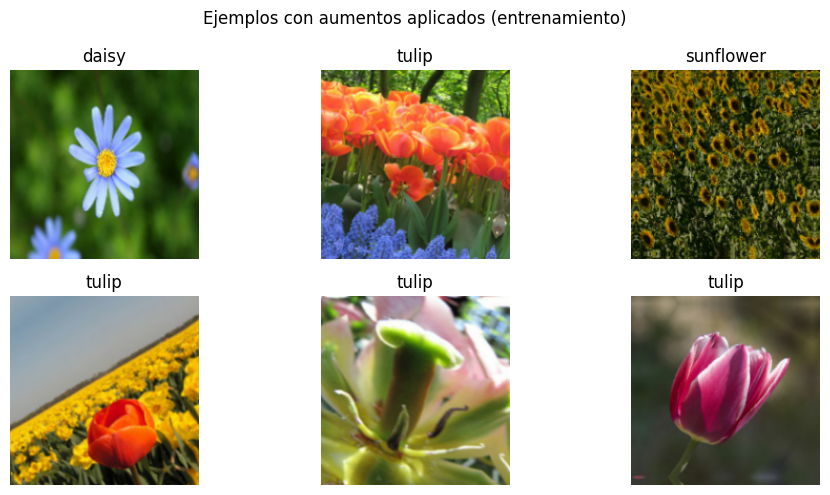

In [7]:
# CELDA 3 (ajustada): Cargar datos desde carpetas y aplicar aumentos con visualización
# -----------------------------------------------------------------------------------
import tensorflow as tf
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt

# Ruta base
ROOT = Path("/content/drive/MyDrive/modulo_4_cv_nlp")
PROC = ROOT / "data" / "processed" / "flowers"

# Parámetros de entrada
BATCH_SIZE = 32
IMG_SIZE = (180, 180)
SEED = 42
AUTOTUNE = tf.data.AUTOTUNE

# ========================
# 1. Cargar datasets
# ========================

# Paso 1: Cargar train sin transformar para extraer nombres de clase
_raw_train_ds = tf.keras.utils.image_dataset_from_directory(
    directory=PROC / "train",
    labels="inferred",
    label_mode="categorical",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED,
)

class_names = _raw_train_ds.class_names

# Paso 2: Transformar (cache, shuffle, prefetch)
train_ds = _raw_train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

# Paso 3: Validación (sin shuffle)
val_ds = tf.keras.utils.image_dataset_from_directory(
    directory=PROC / "val",
    labels="inferred",
    label_mode="categorical",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
).cache().prefetch(buffer_size=AUTOTUNE)

# ========================
# 2. Aumentos de entrenamiento
# ========================
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
], name="image_augmentation")

# ========================
# 3. Visualización de ejemplos aumentados
# ========================
for images, labels in _raw_train_ds.take(1):
    augmented = data_augmentation(images)
    plt.figure(figsize=(10, 5))
    for i in range(6):
        ax = plt.subplot(2, 3, i + 1)
        plt.imshow(tf.cast(augmented[i], tf.uint8))
        plt.title(class_names[tf.argmax(labels[i]).numpy()])
        plt.axis("off")
    plt.suptitle("Ejemplos con aumentos aplicados (entrenamiento)")
    plt.tight_layout()
    plt.show()


#  ¿Qué es `ImageDataGenerator` y por qué es importante?

`ImageDataGenerator` es una clase de **Keras** que permite:

- **Cargar imágenes desde carpetas** automáticamente, organizadas por clase.
- **Preprocesarlas en tiempo real**: escalado, rotación, zoom, recorte, etc.
- **Aplicar aumentos de datos** (*data augmentation*): simula más datos a partir de los mismos ejemplos.

## ¿Por qué es importante en Visión por Computador?

En tareas de clasificación de imágenes:

- **Los modelos de IA son sensibles a sobreajuste** cuando hay pocos datos.
- El `ImageDataGenerator` ayuda a generar variaciones **realistas** (como girar o voltear una flor).
- Esto mejora la **capacidad de generalización** del modelo.

## Beneficios

- Aumenta la **robustez** del modelo.
- Mejora el **rendimiento** con pocos datos.
- Simplifica la carga y etiquetado de imágenes desde carpetas.

---
**Alternativa moderna** (más usada en TF >=2.3):  
```python
tf.keras.utils.image_dataset_from_directory(...)

In [8]:
# CELDA 4: Definir modelo MobileNetV2 + entrenamiento
# -----------------------------------------------------------------------------------
import tensorflow as tf
from tensorflow.keras import layers, models
from pathlib import Path

# Ruta para guardar modelo
ROOT = Path("/content/drive/MyDrive/modulo_4_cv_nlp")
MODEL_DIR = ROOT / "models" / "cv"
MODEL_DIR.mkdir(parents=True, exist_ok=True)

# ========================
# 1. Modelo base
# ========================

# Cargar MobileNetV2 sin la capa final (include_top=False)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(180, 180, 3),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False  # congelar pesos

# Aumento y preprocesamiento + clasificador
inputs = tf.keras.Input(shape=(180, 180, 3))
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(len(class_names), activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)

# ========================
# 2. Compilar modelo
# ========================
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

# ========================
# 3. Entrenamiento
# ========================
EPOCHS = 5  # Puedes aumentar si deseas más rendimiento
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

# ========================
# 4. Guardar modelo entrenado
# ========================
model_path = MODEL_DIR / "mobilenetv2_flowers.h5"
model.save(model_path)
print(f"[ok] Modelo guardado en: {model_path}")


/tmp/ipython-input-2464723034.py:17: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 6, 6, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │         6,405 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,264,389 (8.64 MB)

 Trainable params: 6,405 (25.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/5
109/109 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - accuracy: 0.5638 - loss: 1.0880 - val_accuracy: 0.8270 - val_loss: 0.4761
Epoch 2/5
109/109 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - accuracy: 0.8385 - loss: 0.4695 - val_accuracy: 0.8443 - val_loss: 0.4169
Epoch 3/5
109/109 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.8515 - loss: 0.4126 - val_accuracy: 0.8454 - val_loss: 0.4024
Epoch 4/5
109/109 ━━━━━━━━━━━━━━━━━━━━ 142s 995ms/step - accuracy: 0.8766 - loss: 0.3334 - val_accuracy: 0.8570 - val_loss: 0.3673
Epoch 5/5
109/109 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.8963 - loss: 0.2920 - val_accuracy: 0.8616 - val_loss: 0.3519


[ok] Modelo guardado en: /content/drive/MyDrive/modulo_4_cv_nlp/models/cv/mobilenetv2_flowers.h5


# Modelo base: MobileNetV2 para clasificación de imágenes

## ¿Qué es MobileNetV2?

`MobileNetV2` es una arquitectura de red neuronal convolucional **ligera y eficiente**, diseñada para usarse en dispositivos con recursos limitados como celulares, cámaras o microcontroladores.

- Fue desarrollada por Google (2018).
- Usa bloques llamados *depthwise separable convolutions*, que reducen el número de parámetros.
- Tiene buen rendimiento en tareas de visión, con bajo costo computacional.

## ¿Por qué lo usamos aquí?

Porque queremos **entrenar rápido** sin necesidad de construir una red desde cero, y aprovechamos que ya fue **preentrenada en ImageNet** (con millones de imágenes reales).

## ¿Qué hicimos en este proyecto?

1. **Cargamos MobileNetV2 sin su capa final** (`include_top=False`), para usarla como extractor de características.
2. **Congelamos sus pesos**, para no reentrenar la parte convolucional (más rápido).
3. **Agregamos una capa de clasificación final**:
   - `GlobalAveragePooling2D`: reduce la salida de la red a un vector.
   - `Dropout`: evita sobreajuste.
   - `Dense(softmax)`: predice probabilidades para cada clase.

## ¿Cómo se entrena?

Solo se entrena la "cabeza" del modelo (clasificador final). Esto se llama **transfer learning**.

## ¿Dónde se usa en la vida real?

- Clasificación de productos en supermercados.
- Identificación de plantas, animales, objetos en apps móviles.
- Cámaras inteligentes para seguridad o monitoreo.
- Proyectos en Edge AI (visión por computador en dispositivos físicos).

---
Usar modelos preentrenados acelera el desarrollo y reduce el consumo de recursos.



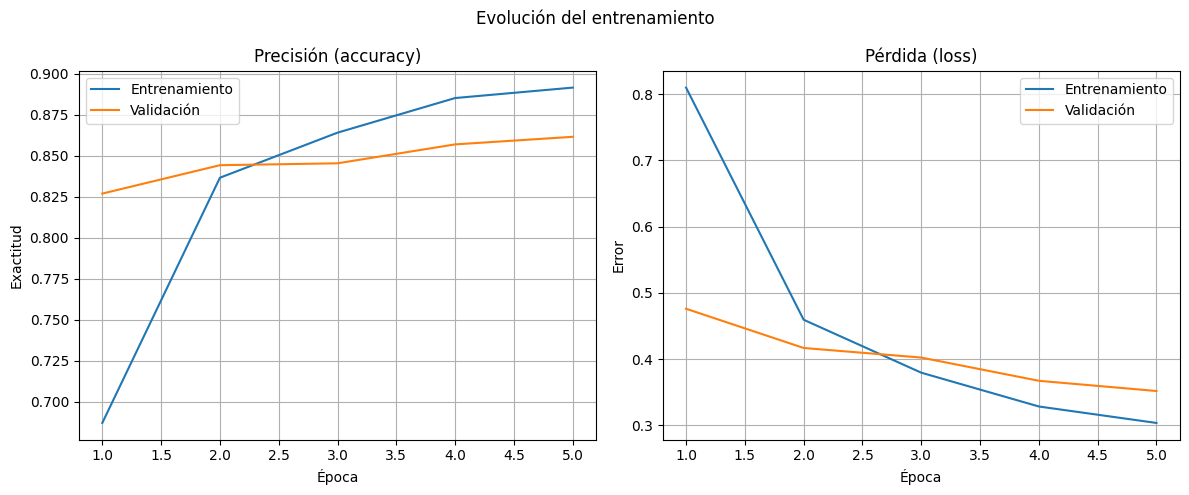

In [9]:
# CELDA 5: Gráficas de rendimiento por época
# -----------------------------------------------------------------------------------
import matplotlib.pyplot as plt

# Extraer historial
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs_range = range(1, len(acc) + 1)

# Gráfica de accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Entrenamiento")
plt.plot(epochs_range, val_acc, label="Validación")
plt.title("Precisión (accuracy)")
plt.xlabel("Época")
plt.ylabel("Exactitud")
plt.legend()
plt.grid(True)

# Gráfica de loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Entrenamiento")
plt.plot(epochs_range, val_loss, label="Validación")
plt.title("Pérdida (loss)")
plt.xlabel("Época")
plt.ylabel("Error")
plt.legend()
plt.grid(True)

plt.suptitle("Evolución del entrenamiento")
plt.tight_layout()
plt.show()


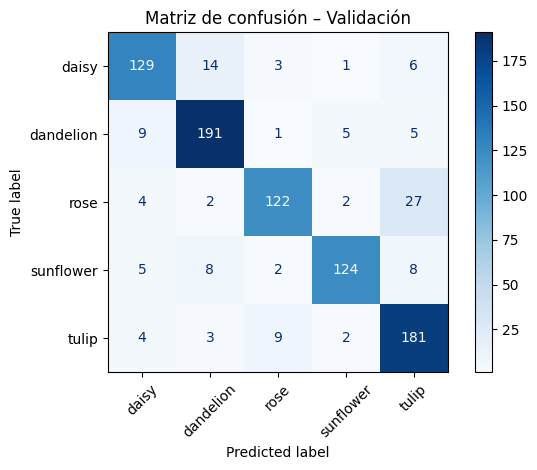

[ok] Métricas guardadas en: /content/drive/MyDrive/modulo_4_cv_nlp/metrics/cv/metrics_val.csv


In [10]:
# CELDA 6: Evaluación, matriz de confusión y exportación de métricas
# -----------------------------------------------------------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from pathlib import Path

# 1. Obtener predicciones y etiquetas verdaderas
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images, verbose=0)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# 2. Reporte de clasificación
report = classification_report(
    y_true,
    y_pred,
    target_names=class_names,
    output_dict=True
)
df_report = pd.DataFrame(report).transpose()

# 3. Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Matriz de confusión – Validación")
plt.tight_layout()
plt.show()

# 4. Guardar métricas en CSV
metrics_path = Path("/content/drive/MyDrive/modulo_4_cv_nlp/metrics/cv/metrics_val.csv")
df_report.to_csv(metrics_path, index=True)
print(f"[ok] Métricas guardadas en: {metrics_path}")


### 🔧 Celda 7 (Opcional): *Fine-tuning* de MobileNetV2

Una vez entrenado el modelo base con capas congeladas, es posible aplicar una fase adicional llamada **fine-tuning**. Esta técnica consiste en "descongelar" algunas capas internas del modelo preentrenado para permitir que se ajusten específicamente a nuestro conjunto de datos.

#### ¿Por qué hacer *fine-tuning*?
- El modelo base (MobileNetV2) fue entrenado con imágenes genéricas (ImageNet).
- Nuestro dominio específico (flores u otra categoría) puede beneficiarse de refinar las representaciones internas.
- Si tenemos más datos o usamos data augmentation, podemos afinar sin sobreajustar.

#### ¿Qué se hace en esta fase?
- Se cargan los pesos previamente entrenados.
- Se descongelan capas profundas seleccionadas del modelo base.
- Se entrena nuevamente con una tasa de aprendizaje más baja.
- Se guarda un nuevo modelo ajustado (`mobilenetv2_finetuned.h5`).

> Recomendado solo si tienes tiempo de entrenamiento suficiente y datos variados.  
> No es obligatorio para un prototipo funcional.



# ¿Para qué sirve este modelo de clasificación de imágenes?

Este proyecto es una versión simplificada de los sistemas reales de visión artificial que se usan en muchas industrias. Al entrenar un modelo que reconoce imágenes (por ejemplo, distintos tipos de flores), aprendiste a implementar un flujo básico pero completo de reconocimiento visual con IA.

## 🌍 Aplicaciones reales

- **Agricultura inteligente**: detectar enfermedades en plantas, clasificar tipos de cultivos o flores automáticamente a partir de imágenes.
- **Comercio electrónico**: identificar productos por foto para catálogos o búsqueda visual (ej: subir una flor y ver opciones de compra similares).
- **Medicina**: analizar imágenes médicas (como radiografías) para identificar patrones o clasificaciones relevantes.
- **Seguridad**: reconocimiento de objetos o personas en cámaras de vigilancia, o inspección visual automatizada en procesos industriales.

## Habilidades que se desarrollaron

- Preprocesamiento y carga de datos visuales
- Uso de modelos preentrenados (MobileNetV2)
- Transfer learning
- Entrenamiento, evaluación y guardado de modelos
- Organización estructurada del proyecto (datasets, métricas, código, modelos)
- Reproducibilidad con `README` y `requirements.txt`

---

**En resumen:** este tipo de sistema te permite resolver problemas visuales reales. Aprenderlo te da las bases para crear soluciones en múltiples sectores que usan imágenes como insumo principal.
